In [1]:
# Load requird packaes
library(tidyverse)
library(patchwork)
library(slider)
library(scam)

── Attaching packages ─────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-41. For overview type 'help("mgcv-package")'.

This is scam 1.2-12.



In [56]:
# Functions sourced by other scripts in Snakemake pipeline

#' Load results from marker BLAST
#' 
#' @param path Path to marker blast results
#' 
#' @return Tibble/Dataframe with BLAST results
load_marker_blast <- function(path){
  
    # Column names
    cols <- c('qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'qlen', 'sstart', 'send', 'slen', 'evalue', 'bitscore', 'qcovs', 'qcovhsp')

    # Read in BLAST results
    markers_blast <- read.delim(path, sep = '\t', col.names = cols) %>%
        mutate(qseqid = as.character(qseqid)) %>%

    return(markers_blast)
}

#' Function to load genetic map from Olsen et al. (2021)
#' 
#' @param path Path to genetic map
#' 
#' @return Genetic map as Dataframe
load_genMap <- function(path){
    
    # Load genetic map
    genMap <- read.csv(path) %>%
        
        # Re-map linkage group names to chromosomes
        # Mean that linkage group in marker name won't match chromosome number, but that's fine
        mutate(LG = case_when(LG == 1 ~  'Chr01_Occ' ,
                              LG == 2 ~  'Chr02_Occ' ,
                              LG == 3 ~  'Chr03_Occ' ,
                              LG == 4 ~  'Chr04_Occ' ,
                              LG == 5 ~  'Chr05_Occ' ,
                              LG == 6 ~  'Chr06_Occ' ,
                              LG == 7 ~  'Chr07_Occ' ,
                              LG == 8 ~  'Chr08_Occ' ,
                              LG == 9 ~  'Chr01_Pall',
                              LG == 10 ~ 'Chr02_Pall',
                              LG == 11 ~ 'Chr03_Pall',
                              LG == 12 ~ 'Chr04_Pall',
                              LG == 13 ~ 'Chr05_Pall',
                              LG == 14 ~ 'Chr06_Pall',
                              LG == 15 ~ 'Chr07_Pall',
                              LG == 16 ~ 'Chr08_Pall'))
    return(genMap)
}


#' Filter dataframe to only include markers in window
#'
#' @param window_start Start position of window
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with markers 
#'
#' @return Filtered dataframe containing only markers in windows'
get_windows <- function(window_start, window_size, step, df){

    df_filt <- df %>%
        arrange(pos) %>%
        filter(pos >= window_start & pos < window_start + window_size) %>%

        # Get min, max, and mid position of window
        mutate(min_pos = window_start,
               max_pos = window_start + (window_size - step) - 1,
               mid_pos = window_start + (max_pos - min_pos) / 2)
    return(df_filt)
}

#' Calculate mean cM of markers in window
#' 
#' @param chrom_name Character vector with name of chromosome
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with windowed markers
#'
#' @return Dataframe with mean cM in windows
calculate_windowed_means <- function(chrom_name, window_size, step, df){

    df_sub <- df %>% filter(sseqid == chrom_name)
    all_pos <- seq(from = min(df_sub$pos), to = max(df_sub$pos), by = step)
    df_withWindows <- purrr::map_dfr(all_pos, get_windows,
                                   df = df_sub,
                                   window_size = window_size,
                                   step = step,
                                   .id = 'win_id')
    df_winMeans <- df_withWindows %>%
        group_by(win_id, min_pos, max_pos, mid_pos, pop) %>%
        summarise(num_markers = n(),
                  win_mean_cM = mean(cM), .groups = 'keep') %>%
        ungroup() %>%
        group_by(win_id, min_pos, max_pos, mid_pos) %>%
        summarise(win_mean_cM = mean(win_mean_cM), .groups = 'keep') %>%
        mutate(chrom = chrom_name)
    return(df_winMeans)
}

#' Fit Shape Constrained cubic p-spline with 10 knots
#'
#' @param Dataframe with terms to model
#'
#' @return Fitted SCAM model
fit_scam <- function(df){
    fit <- scam(win_mean_cM~s(mid_pos, bs='mpi', k=10, m=2),
              family=gaussian(link="identity"),
              data = df)
    return(fit)
}

#' Interpolate predicted cM from SCAM model
#' 
#' @param fit Fitted SCAM model
#' @param sites Sites to be interpolation
interpolate <- function(fit, sites){
    newdata <- data.frame(mid_pos = sites$pos)
    preds <- predict(fit, newdata)
    return(preds)
}

#' Fit SCAM model and add predicted cM to dataframe
#' 
#' @param chrom_name Name of chromosome to be fit
#' @param markers_df Dataframe with markers for model fitting
#' @param sites_df Dataframe with sites to be interpolated
#'
#' @return Dataframe with predicted cM at each position
get_fits <- function(chrom_name, markers_df, sites_df){

    print(sprintf("Fitting chromosome %s", chrom_name))
    markers <- markers_df %>% filter(chrom == chrom_name)
    sites <- sites_df %>% filter(chrom == chrom_name)

    fit <- fit_scam(df = markers)
    predicted <- interpolate(fit, sites)

    sites$preds <- predicted
    return(sites)
}

#' Plot SCAM fit
#'
#' @param chrom_name Name of chromosome to be fit
#' @param markers_df Dataframe with markers for model fitting
#' @param scam_fits_df Dataframe with predicted values from SCAM fit
#'
#' @return ggplot object
scam_plot <- function(chrom_name, markers_df, scam_fits_df){

    markers <- filter(markers_df, chrom == chrom_name)
    scamFit <- filter(scam_fits_df, chrom == chrom_name)

    plot <- markers %>%
        ggplot(., aes(x = mid_pos, y = win_mean_cM_off)) +
        geom_point(size = 2.5, color = 'black', shape = 21, fill = 'black', show.legend = FALSE) +
        geom_line(data = scamFit, aes(x = pos, y = preds), size = 1, color = 'red') +
        xlab('Physical position') + ylab('Genetic position (cM)') +
        ggtitle(chrom_name) +
        theme_classic() +
        theme(axis.title = element_text(size = 15),
              axis.text = element_text(size = 13))

    return(plot)
}



In [21]:
# Assign input files to variables
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'
DG_markers <- load_marker_blast(paste0(results_prefix, 'gen_map/DG_marker_blast.txt')) %>%
    mutate(pop = 'DG')
SG_markers <- load_marker_blast(paste0(results_prefix, 'gen_map/SG_marker_blast.txt')) %>%
    mutate(pop = 'SG')

# Load both genetic maps from Olsen et al. 
DG_genMap <- load_genMap('../resources/genMap/DG_genMap.csv') %>%
    mutate(pop = 'DG')
SG_genMap <- load_genMap('../resources/genMap/SG_genMap.csv') %>%
    mutate(pop = 'SG')

# Load files with marker names
DG_names <- read.csv('../resources/genMap/DG_marker_key.csv', col.names = c('qseqid', 'name')) %>%
    mutate(pop = 'DG')
SG_names <- read.csv('../resources/genMap/SG_marker_key.csv', col.names = c('qseqid', 'name')) %>%
    mutate(pop = 'SG')

# # Load sites files for interpolation
sites_allChroms <- list.files(paste0(results_prefix, 'program_resources/genMap_interpolation'), full.names = T) %>%
    purrr::map_dfr(., read_delim, delim='\t', col_names=c('chrom', 'pos'))

Rows: 324386 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 310313 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 227586 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chrom
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 229919 Columns: 2
── Column specif

In [30]:
# Combine genetic maps from both populations
all_maps <- bind_rows(SG_genMap, DG_genMap)

# Combine marker names
all_names <- bind_rows(SG_names, DG_names)

# Combine markers from both mapping populations
all_markers <- bind_rows(SG_markers, DG_markers) %>% 
    left_join(., all_names, by = c('qseqid', 'pop'))  %>% 
    left_join(., all_maps, by = c('name', 'pop'))

In [35]:
all_markers_filtered <- all_markers %>%
    group_by(name) %>%

    # Only use markers that BLAST to the correct chromosome based on Olsen LG data
    filter(sseqid == LG) %>% 

    # Only use the best long alignment with high pident
    filter(pident >= 95 & length > 175) %>%
    filter(evalue == min(evalue))

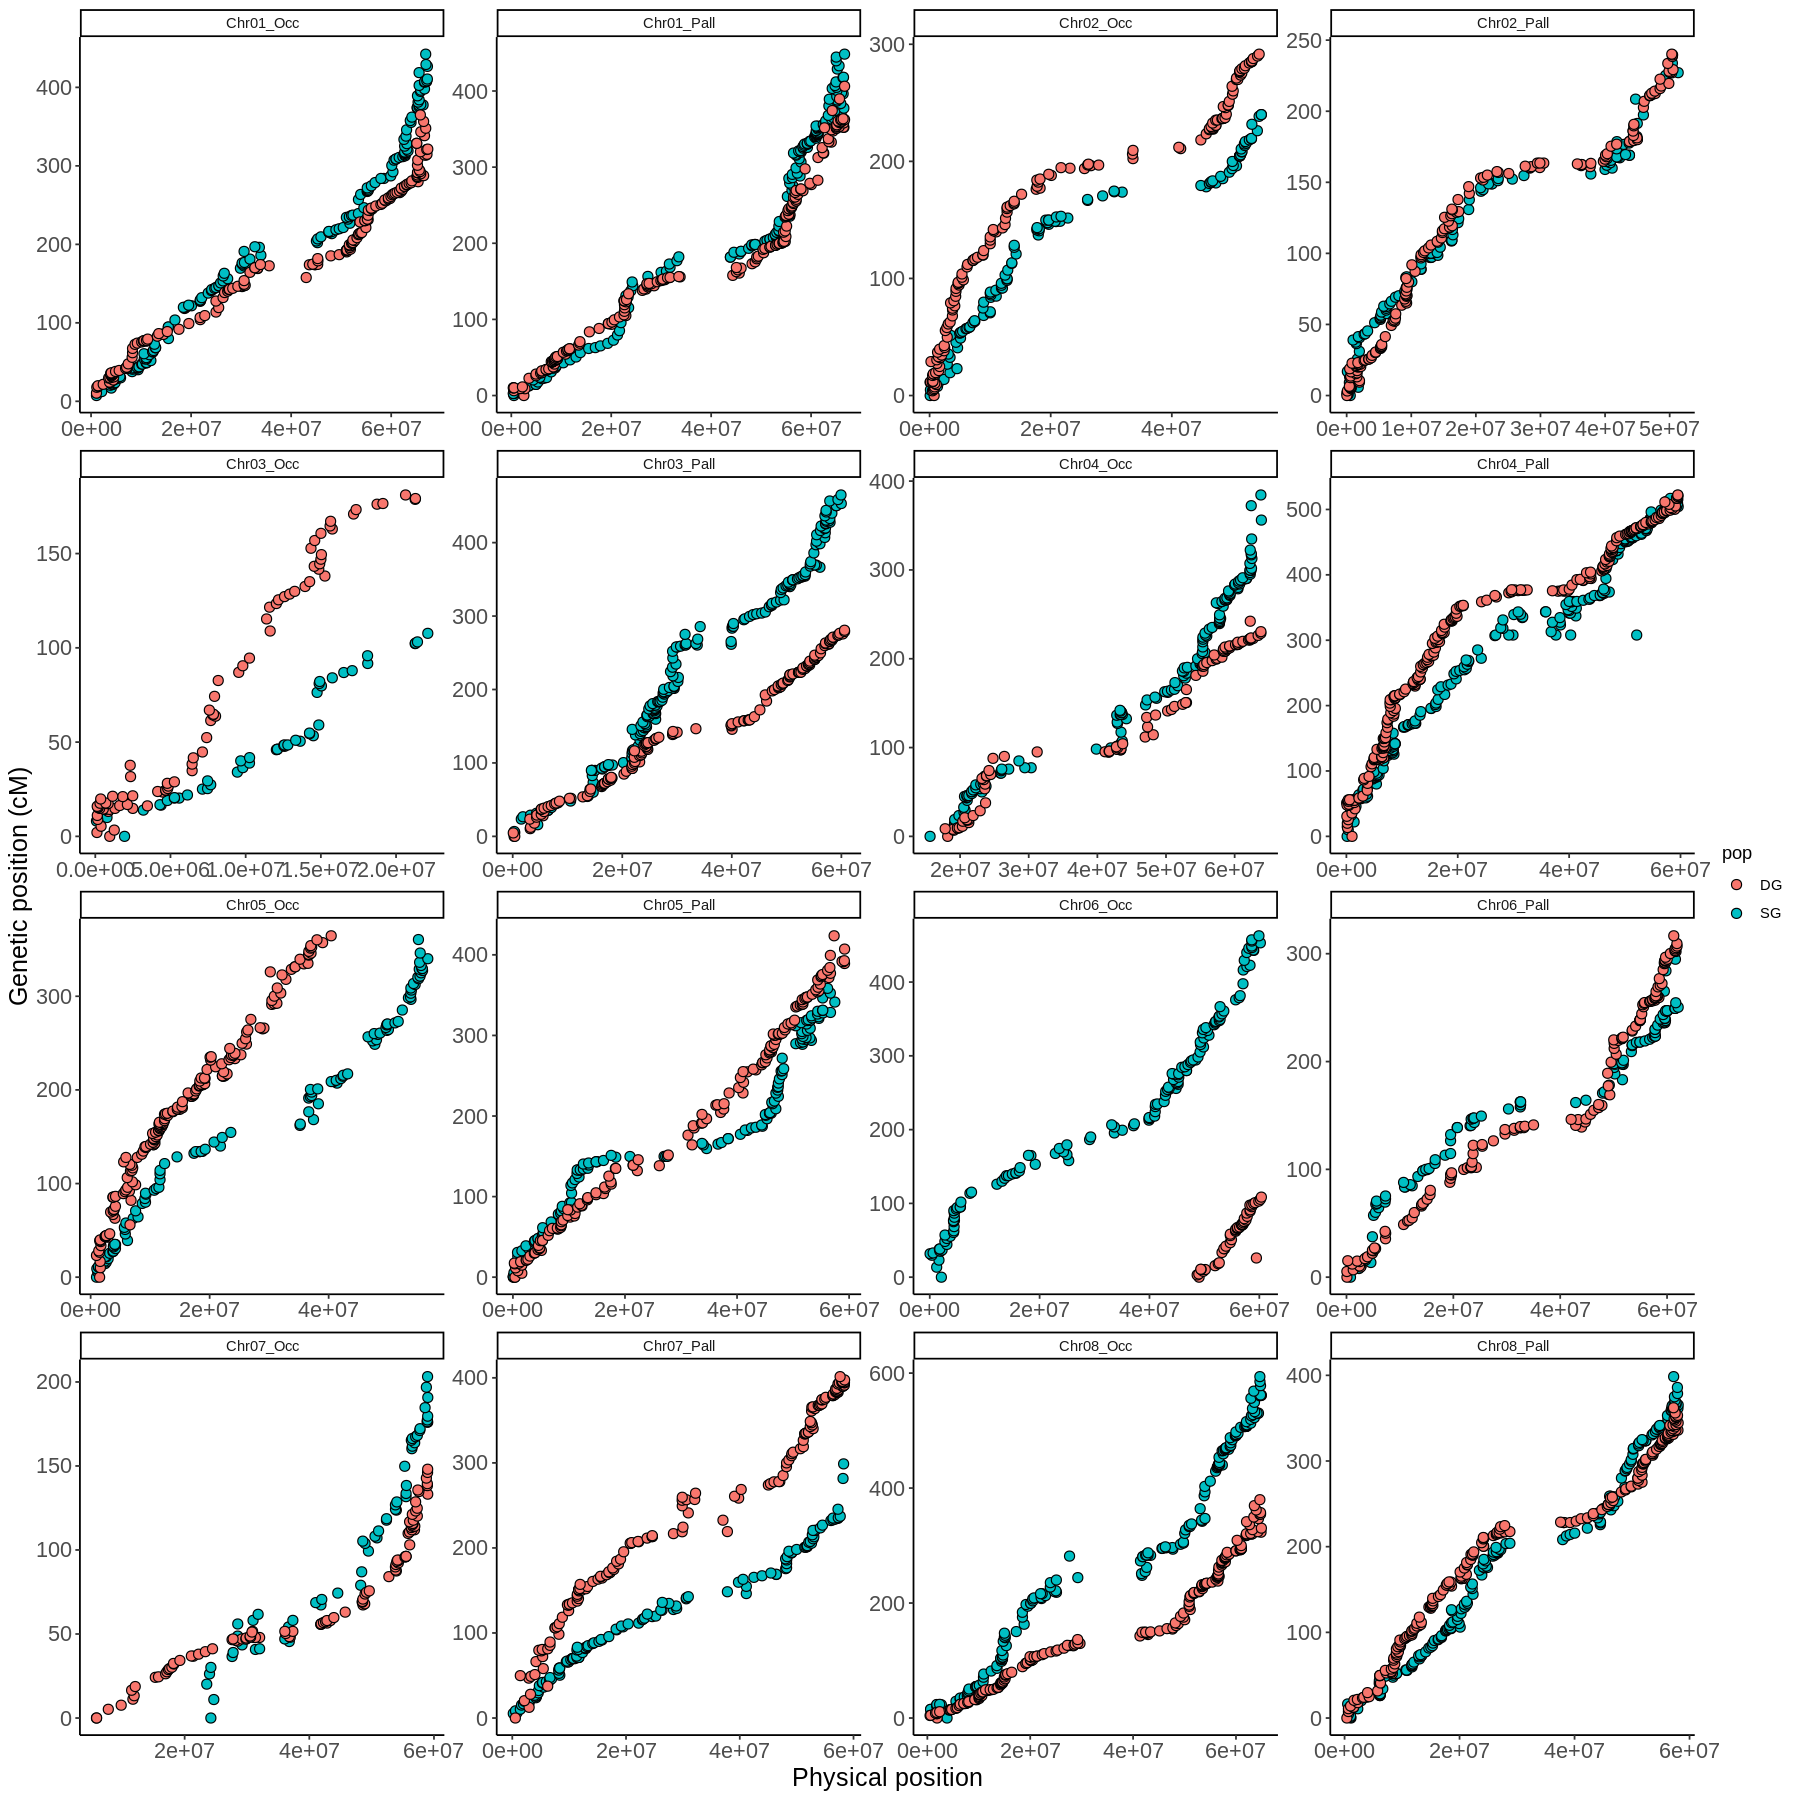

In [50]:
options(repr.plot.width = 15, repr.plot.height = 15)
all_markers_filtered_plot_byChr_byPop <- all_markers_filtered %>%
    ggplot(., aes(x = sstart, y = cM)) +
    geom_point(size = 2.5, aes(fill = pop), shape = 21, color = 'black') +
    xlab('Physical position') + ylab('Genetic position (cM)') +
    facet_wrap(~sseqid, scales = 'free') +
    theme_classic() +
    theme(axis.title = element_text(size = 15),
          axis.text = element_text(size = 13))
all_markers_filtered_plot_byChr_byPop

In [58]:
# Remove DG mapping pop markers from Chr06_Occ
final_markers_bothPops <- all_markers_filtered %>% 
    filter(!(sseqid == 'Chr06_Occ' & pop == 'DG')) %>% 
    mutate(pos = sstart + 99)  # Since 100 bp markers

In [69]:
# Get mean cM across both maps in windows
chroms <- final_markers_bothPops %>% pull(sseqid) %>% unique()
winMeans_df <- chroms %>%
    purrr::map_dfr(., calculate_windowed_means, 
                   window_size = 5000000,
                   step = 1000000,
                   df = final_markers_bothPops)

In [72]:
# Fit SCAM model separately for each chromosome
scamFits_allChroms <- chroms %>%
    purrr::map_dfr(., get_fits, markers_df = winMeans_df, sites_df = sites_allChroms) 

[1] "Fitting chromosome Chr01_Occ"
[1] "Fitting chromosome Chr02_Occ"
[1] "Fitting chromosome Chr03_Occ"
[1] "Fitting chromosome Chr04_Occ"
[1] "Fitting chromosome Chr05_Occ"
[1] "Fitting chromosome Chr06_Occ"
[1] "Fitting chromosome Chr07_Occ"
[1] "Fitting chromosome Chr08_Occ"
[1] "Fitting chromosome Chr01_Pall"
[1] "Fitting chromosome Chr02_Pall"
[1] "Fitting chromosome Chr03_Pall"
[1] "Fitting chromosome Chr04_Pall"
[1] "Fitting chromosome Chr05_Pall"
[1] "Fitting chromosome Chr06_Pall"
[1] "Fitting chromosome Chr07_Pall"
[1] "Fitting chromosome Chr08_Pall"


In [73]:
# Find minimum predicted cM
min_cM <- scamFits_allChroms %>% 
    group_by(chrom) %>% 
    summarise(min_cM = min(preds))

In [75]:
# Force minimum predicted cM to 0 for SCAM fits
scamFits_allChroms <- scamFits_allChroms %>% 
    group_by(chrom) %>% 
    mutate(preds = case_when(min(preds) < 0 ~ preds + abs(min(preds)),
                             min(preds) > 0 ~ preds - abs(min(preds))))

In [76]:
# Offset markers by same amount as fits. Only for plotting
winMeans_df <- winMeans_df %>% 
    left_join(., min_cM, by = 'chrom') %>% 
    group_by(chrom) %>% 
    mutate(win_mean_cM_off = case_when(min_cM < 0 ~ win_mean_cM + abs(min_cM),
                                       min_cM > 0 ~ win_mean_cM - abs(min_cM)))

In [77]:
# List of plots. Each plot is fit of SCAM model to chromosome markers
scamFits_plotList <- chroms %>%
    purrr::map(., scam_plot, markers_df = winMeans_df, scam_fits_df = scamFits_allChroms)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [78]:
# Combine list of plots into one
scamFits_allChroms_plot <- wrap_plots(scamFits_plotList, 4, 4)
# ggsave(filename = snakemake@output[['scamFits_plot']], plot = scamFits_allChroms_plot,
#        device = 'pdf', dpi = 600, width = 20, height = 20, units = 'in')

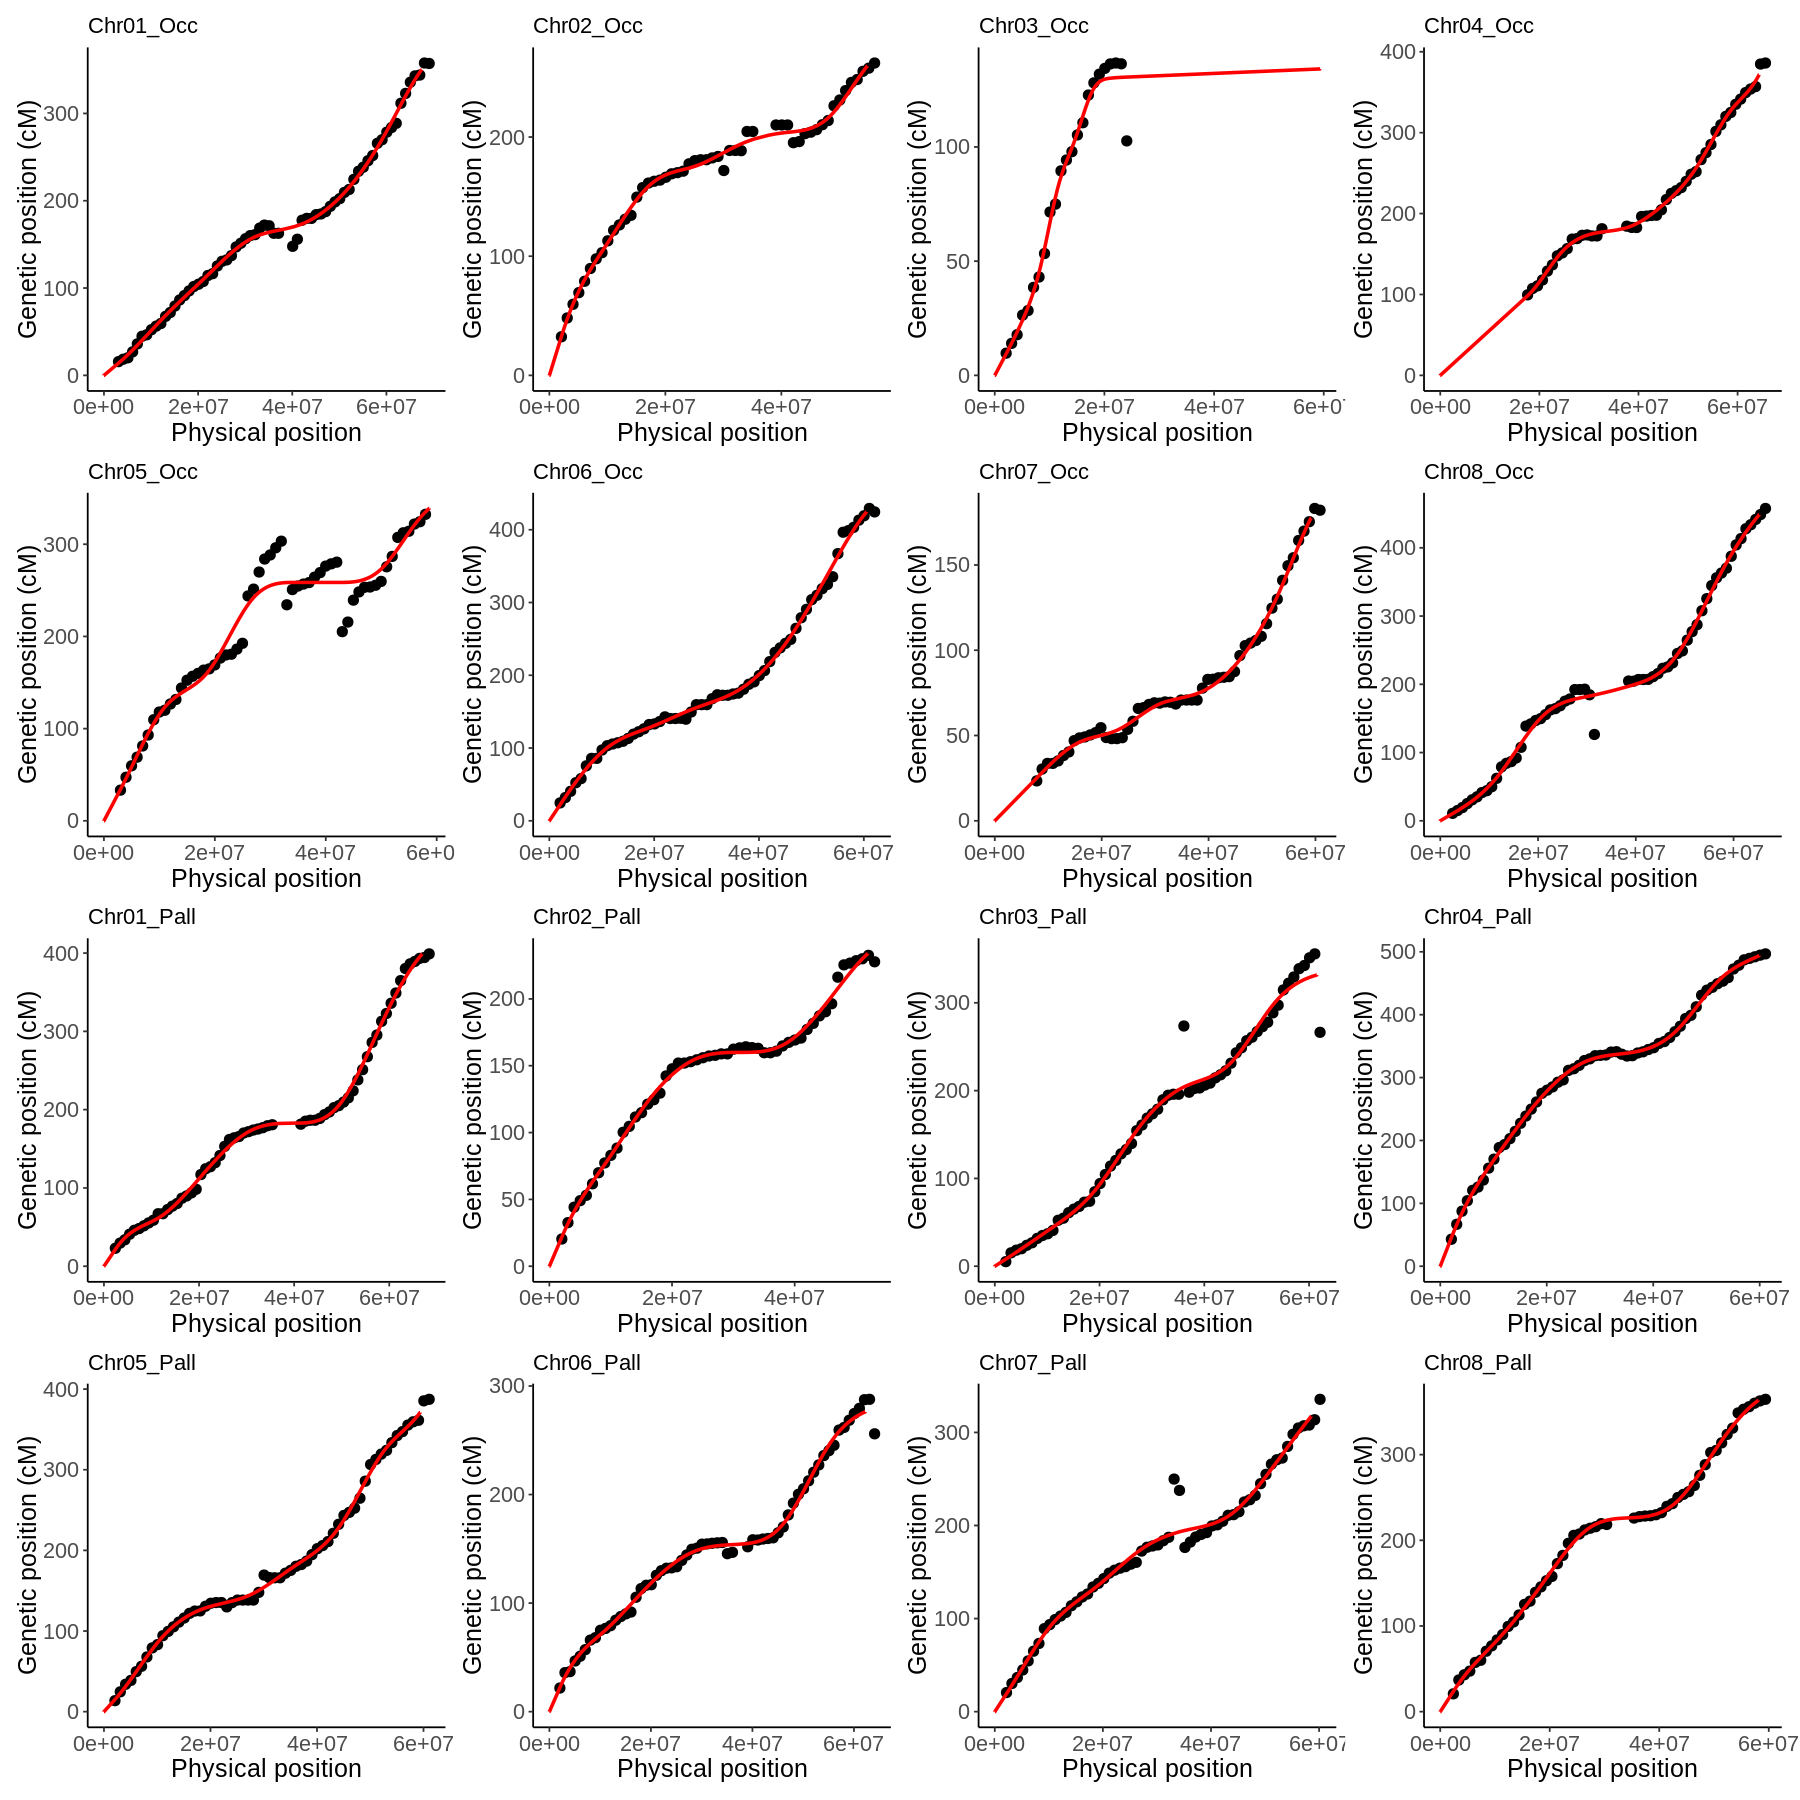

In [79]:
scamFits_allChroms_plot

In [99]:
scamFits_allChroms %>% 
    mutate(pos_lead = lead(pos),
           pred_lead = lead(preds),
           r = (pred_lead - preds) / (pos_lead / pos) / 100) %>% 
    ungroup() %>% 
    summarise(median = median(r, na.rm = T))

median
<dbl>
6.262008e-07
